In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from numpy import array

In [2]:
tf.executing_eagerly()

True

In [3]:
# Importing data 
dataset = pd.read_csv('cases_four_states.csv')

In [5]:
#Defining test data
test_set_f = np.array(dataset.iloc[-16:310, 1:2])
print(test_set_f.shape)

(16, 1)


In [6]:
#Testing for stationary and non-stationary 
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(dataset['CALIFORNIA'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  0.19670623960858968
2. P-Value :  0.97207625070814
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 300
5. Critical Values :
	 1% :  -3.4523371197407404
	 5% :  -2.871222860740741
	 10% :  -2.571929211111111


In [7]:
# making date as pandas date and setting as a index
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.set_index('date', inplace=True)

In [8]:
# Removing seasonality and trend
# 1- seasonality
import copy
order = 2
coef = np.polyfit(np.arange(len(dataset['CALIFORNIA'])),
                  dataset['CALIFORNIA'].values.ravel(),
                  order)
poly_mdl = np.poly1d(coef)
poly_mdl
trend = pd.Series(data = poly_mdl(np.arange(len(dataset['CALIFORNIA']))),
                  index = dataset.index)
detrended = dataset['CALIFORNIA'] - trend
seasonal = detrended.groupby(by = detrended.index.month).mean()
col = 'CALIFORNIA'
seasonal_component = copy.deepcopy(dataset)
for i in seasonal.index:
    seasonal_component.loc[seasonal_component.index.month == i, col] = seasonal.loc[i]
deseasonal = dataset - seasonal_component

# Removing trend
coef = np.polyfit(np.arange(len(deseasonal)), deseasonal['CALIFORNIA'], order)
poly_mdl = np.poly1d(coef)
trend_comp = pd.DataFrame(data = poly_mdl(np.arange(len(dataset['CALIFORNIA']))),
                          index = dataset.index,
                          columns=['CALIFORNIA'])

residual = dataset - seasonal_component - trend_comp

In [10]:
# seasonality and trend of test data
trend_comp_test = trend_comp.iloc[-16:310, 0:1]
seasonal_component_test = seasonal_component.iloc[-16:310, 0:1]
print(seasonal_component_test.shape)

(16, 1)


In [11]:
# selecting main feature
training_data = residual.iloc[:, 0:1].values

In [12]:
# Defining traning set and test set
num_data = len(training_data)
train_split = 0.95
num_train = int(train_split * num_data)
num_test = num_data - num_train
training_set = training_data[0:num_train]
test_set = training_data[num_train:]

In [13]:
print(training_set.shape)
print(test_set.shape)

(294, 1)
(16, 1)


In [14]:
#scaling 
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [15]:
#creating sequence length 
# For this problem, the model is trained based on data from last 14 days to predict the next day.
x_train = []
y_train = []
for i in range(14, 294):
    x_train.append(training_set_scaled[i-14:i, 0:1])
    y_train.append(training_set_scaled[i, 0:1])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],x_train.shape[2]))

In [16]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')


In [17]:
# Multivariate Guassian kernel
def calc_pdf(y, mu, var):
    value = tf.subtract(y, mu)**2
    value = (1/tf.math.sqrt(2 * np.pi * var)) * tf.math.exp((-1/(2*var)) * value)
    return value

In [18]:
# Error function in terms of negative logarithm likelihood 
def mdn_loss(y_true, pi, mu, var):
    out = calc_pdf(y_true, mu, var)
    # multiply with each pi and sum it
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    return tf.reduce_mean(out)

In [33]:
# building RNN

inputs1= Input(shape = (x_train.shape[1],x_train.shape[2]))
lstm1 = LSTM(10, return_sequences=True, dtype='float32')(inputs1)
lstm3 = LSTM(10, dtype='float32')(lstm1)
layer = tf.keras.layers.Dense(10, dtype='float32')(lstm3)

#  input feature
l = 1
# Number of gaussians to represent the multimodal distribution
k = 1

mu = tf.keras.layers.Dense((l * k), activation=None, dtype='float32')(layer)

var = tf.keras.layers.Dense(k, activation=K.exp, dtype='float32')(layer)

pi = tf.keras.layers.Dense(k, activation='softmax', name='pi_layer', dtype='float32')(layer)
model = tf.keras.models.Model(inputs1, [pi, mu, var])

outputs = [pi, mu, var]
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss={'output':mdn_loss})

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 14, 10)       480         input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 10)           840         lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           110         lstm_3[0][0]                     
_______________________________________________________________________________________

In [34]:
N = x_train.shape[0]
dataset = tf.data.Dataset \
    .from_tensor_slices((x_train, y_train)) \
    .shuffle(N).batch(N)

In [35]:
#borrowed from https://www.katnoria.com/mdn/
def train_step(model, optimizer, train_x, train_y):
    # GradientTape: Trace operations to compute gradients
    with tf.GradientTape() as tape:
        pi_, mu_, var_ = model(train_x, training=True)
        # calculate loss
        loss = mdn_loss(train_y, pi_, mu_, var_)
    # compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [36]:
losses = []
EPOCHS = 1000
print_every = int(0.2 * EPOCHS)

# Define model and optimizer
model = tf.keras.models.Model(inputs1, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()

# Start training
print('Print every {} epochs'.format(print_every))
for i in range(EPOCHS):
    for train_x, train_y in dataset:
        loss = train_step(model, optimizer, train_x, train_y)
        losses.append(loss)
    if i % print_every == 0:
        print('Epoch {}/{}: loss {}'.format(i, EPOCHS, losses[-1]))       

Print every 200 epochs
Epoch 0/1000: loss 1.0019546747207642
Epoch 200/1000: loss -0.7508595585823059
Epoch 400/1000: loss -0.8270707130432129
Epoch 600/1000: loss -0.8409181833267212
Epoch 800/1000: loss -0.8497732877731323


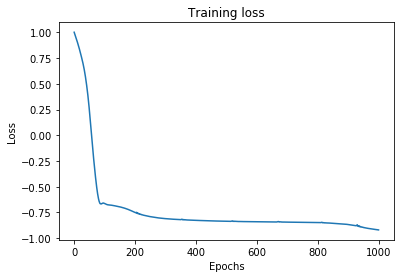

In [37]:
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [38]:
# Building the test data
dataset_total = training_data
inputs = dataset_total[len(dataset_total)- len(test_set)-14:]
inputs= np.reshape(inputs, (inputs.shape[0], inputs.shape[1]))
inputs = sc.transform(inputs)
x_test = []
for i in range(14, 30):
    x_test.append(inputs[i-14:i, 0:1])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],x_test.shape[2]))

In [39]:
x_test = x_test.astype('float32')

In [40]:
#borrowed from https://www.katnoria.com/mdn/
# Creating a sample of a number of points from the distribution and
#generate a dense set of predictions instead of picking just one.
def sample_predictions(pi_vals, mu_vals, var_vals, samples=1):
    n, k = pi_vals.shape
    # print('shape: ', n, k, l)
    # place holder to store the y value for each sample of each row
    out = np.zeros((n, samples, l))
    for i in range(n):
        for j in range(samples):
            # for each sample, use pi/probs to sample the index
            # that will be used to pick up the mu and var values
            idx = np.random.choice(range(k), p=pi_vals[i])
            for li in range(l):
                # Draw random sample from gaussian distribution
                out[i,j,li] = np.random.normal(mu_vals[i, idx*(li+l)], np.sqrt(var_vals[i, idx]))
    return out    

In [41]:
# Get predictions
pi_vals, mu_vals, var_vals = model.predict(x_test)


In [42]:
sampled_predictions = sample_predictions(pi_vals, mu_vals, var_vals, 1)

In [43]:
sampled_predictions.shape

(16, 1, 1)

In [44]:
predicted_set = sampled_predictions.reshape(sampled_predictions.shape[0], sampled_predictions.shape[2])
predicted_set = sc.inverse_transform(predicted_set)
print(predicted_set.shape)

(16, 1)


In [45]:
# Adding seasonality and trend to test set
predicted_set_f= []
trend_comp_test = np.array(trend_comp_test)
seasonal_component_test = np.array(seasonal_component_test)
predicted_set_f = np.array([[predicted_set[i][j] + trend_comp_test[i][j] + seasonal_component_test[i][j] 
                    for j in range (len(predicted_set[0]))] for i in range(len(predicted_set))])

In [46]:
test_dataframe = pd.DataFrame(test_set_f)  
predict_dataframe = pd.DataFrame((predicted_set_f))
#predict_dataframe = predict_dataframe.astype(int)  
test_dataframe.to_csv(r'C:\Users\mdavahli\Desktop\twitter\TEST.csv')
predict_dataframe.to_csv(r'C:\Users\mdavahli\Desktop\twitter\PREDICT.csv')